# Nuclear Stability Machine Learning Model Application

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os

from sqlalchemy import create_engine 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [2]:
# Load data from sql
engine = create_engine('sqlite:///../data/nuclear_physics.db')
df = pd.read_sql('nucleides', engine)

# scikit-learn doesn't accept NaNs, we need to filter them from the relevant columns
df_ml = df.dropna(subset=['NZ_ratio', 'Mass_Excess'])

From the previous section we've seen the most relevant features regarding nuclear stability:
* **Ratio $N/Z$:** Stable nuclei tend to compensate the coulombian repulsion by adding more neutrons.

* **Mass Excess:** Stable nuclei have a larger binding energy, resulting in a more negative mass excess.

* **$A,Z,N$:** Nuclei with an even number of protons and/or neutrons are more stable.

In nature, unstable isotopes vastly outnumber stable ones (around 96% and 4%, respectively). A standard model would achieve 96% accuracy simply by predicting that all nuclei are unstable. We apply SMOTE (Synthetic Minority Over-Sampling Technique) to generate synthetic stable isotopes in the feature space, balancing the dataset to 50/50 for training. This forces the model to learn the actual boundaries of the stability valley, an impossible mission with only 4%. 

In [3]:
features = ['Z', 'N', 'A', 'NZ_ratio', 'Mass_Excess']
X = df_ml[features]
# We want to prodice if the nucleous is stable or unstable
y = df_ml['is_stable'].astype(int)

# We take 70% of the data for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)
# Generating new stable nuclei for training, for better precision
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)

print("Distribution after smote:", y_train_resampled.value_counts().to_dict())
print("Now we have the same amount of stables and unstables nuclei.")

Distribution after smote: {0: 3900, 1: 3900}
Now we have the same amount of stables and unstables nuclei.


In [4]:
# Training with XGBoost
model = XGBClassifier(
    n_estimators = 1250,
    learning_rate = 0.05,
    scale_pos_weight = 1.5, # Making a mistake regarding stable nuclei is punished harder. 
    eval_metric = 'logloss',
    random_state=42
)

model.fit(X_train_resampled, y_train_resampled)

# Prediction
y_pred = model.predict(X_test)
# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"\nModel accuracy: {acc*100:.2f}%")


Model accuracy: 92.62%


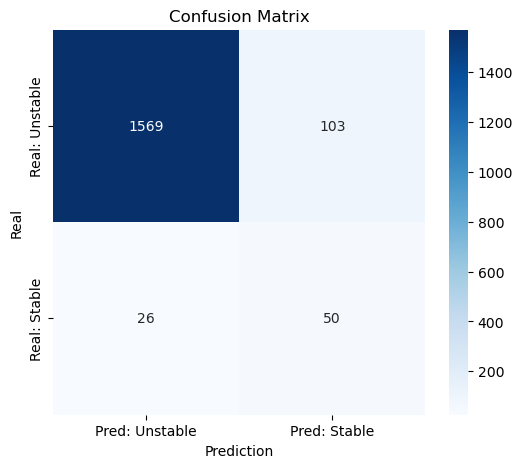

In [5]:
# Confusion matrix
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Pred: Unstable', 'Pred: Stable'],
           yticklabels=['Real: Unstable', 'Real: Stable'])
plt.title('Confusion Matrix')
plt.ylabel('Real')
plt.xlabel('Prediction')

plt.savefig('../assets/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

The model was evaluated on a held-out set representing the 30% of the original data. The confusion matrix reaveals the model's performance:

* **Accuracy:** the model correctly classified 1619 out of 1748 instances, representing a **92.62%** accuracy.
* **Stability Detection (Minority Class):** Out of 76 actual stable isotopes in the test set, the model correctly identified 50 (true positives) resulting in a **Recall of 66%**.
* **False Positives:** The model predicted 103 unstable isotopes as stable. This indicates that while the model has learned the general valley of stability, it tends to be slightly optimistic (as a result of scale_pos_weight=1.5), overestimating the stability of nuclei near the boundaries, although, with less degree of confidence. It is worth noting that many of the 103 false positive might be long-lived unstable isotopes that share similar feature characteristics with stable nuclei.

When the model predicts stability for a determined nucleus, it has a $32.7%$ precission. Considering that there are only $4.35%$ of stable nuclei, the model has a **Lift** $\approx 7.51$. This translates to a 7.5x reduction in experimental costs or search time. 

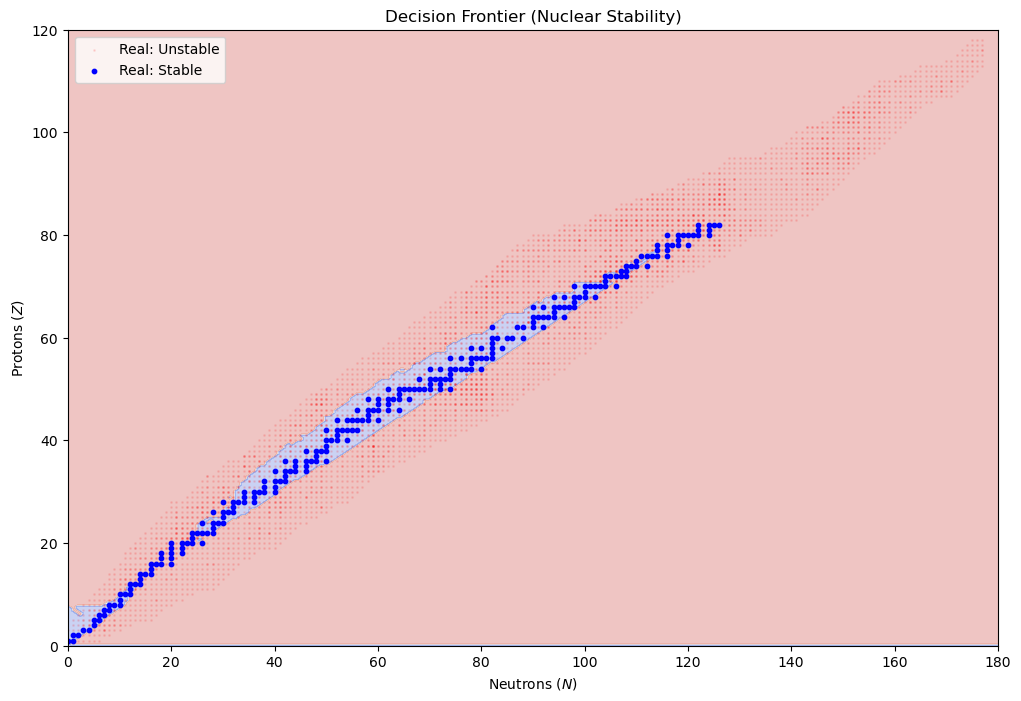

In [6]:
# Define ranges
z_range = np.linspace(0, 120, 300) 
n_range = np.linspace(0, 180, 300) 
xx, yy = np.meshgrid(n_range, z_range)

# We use'with' to avoid division by 0 messages
with np.errstate(divide='ignore', invalid='ignore'):    
    grid_data = pd.DataFrame({
        'Z': yy.ravel(),
        'N': xx.ravel(),
        'A': xx.ravel() + yy.ravel(),
        'NZ_ratio': xx.ravel() / yy.ravel(),
        'Mass_Excess': 0, # Dummy value
    })

# Cleaning infinities and not a numbers
grid_data = grid_data.replace([np.inf, -np.inf], np.nan).fillna(0)

# With .values we pass raw numbers, matching SMOTE format after training
Z_pred = model.predict(grid_data.values).reshape(xx.shape) 
#Z_pred = Z_pred.reshape(xx.shape)

# Plotting
plt.figure(figsize=(12, 8))

# Background color (prediction)
plt.contourf(xx, yy, Z_pred, alpha=0.3, cmap='coolwarm_r')

# Actual Data on front
plt.scatter(df_ml[df_ml['is_stable']==0]['N'], df_ml[df_ml['is_stable']==0]['Z'], 
            c='red', s=1, alpha=0.1, label='Real: Unstable')
plt.scatter(df_ml[df_ml['is_stable']==1]['N'], df_ml[df_ml['is_stable']==1]['Z'], 
            c='blue', s=10, label='Real: Stable')

plt.title('Decision Frontier (Nuclear Stability)')
plt.xlabel('Neutrons ($N$)')
plt.ylabel('Protons ($Z$)')
plt.legend()

plt.savefig('../assets/decision_boundary.png', dpi=300, bbox_inches='tight')
plt.show()

The plot ilustrates the classification landscape learned by the XGBoost model. 

* **Colored regions:** The background color represents the model prediction for any given coordinate (N,Z). The blue region denotes the area where the model predicts stability, while the red corresponds to instability.
* **Data points:** The overlaid dots represent the actual experimental data from the NUBASE2020 dataset, with the same color asignment.

The model has successfully reconstructed the Valley of Stability purely from training data, without explicit programming of nuclear physics equations. It captures the characteristic deviation from the $N=Z$ line for heavier nuclei, driven by Coulomb repulsion. The tight overlap between the blue decision region and the blue data points visually confirms the model high accuracy, even though it overestimates its width. 

It is important to note the step-wise or jagged edges of the blue stability region. This geometric characteristic is intrinsic to tree-based algorithms (like Random Forest and XGBoost) which make orthogonal splits in the feature space. Unlike linear classifiers (like Logistic Regression) that would produce a smooth linea, the tree-ensemble model effectively captures the non-linear and complex manifold of nuclear stability, wrapping closely around the true stable isotopes

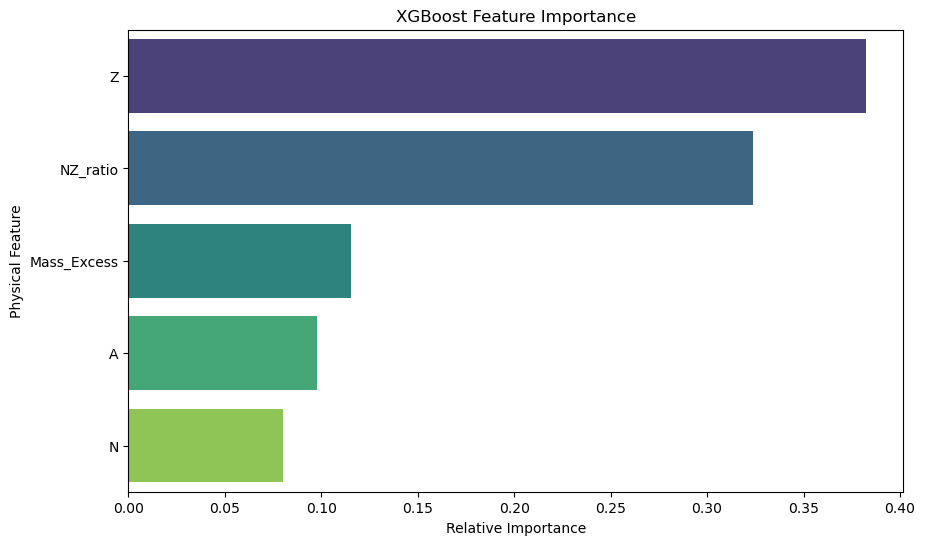

In [7]:
# Importance
Importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=Importance, 
            x = 'Importance', 
            y = 'Feature', 
            hue = 'Feature',
            legend = False,
            palette = 'viridis')

plt.title('XGBoost Feature Importance')
plt.xlabel('Relative Importance')
plt.ylabel('Physical Feature')
plt.savefig('../assets/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

The figure displays the "Feature Importance" scores, which represent the relative contribution of each variable to the model's decision-making process. The values sum to 1, indicating the percetage of information gain attributable to each feature. 

* **Dominance of Proton Number:** The model identifies the atomic number as the single most critical factor, this aligns with nuclear theory as the Coulomb Repulsion between protons is the primary destabilizing force that limits the size of the nucleus.
* **Neutron-to-Proton ratio:** This is the second most influential feature. It confirms that stability is not just about size, but about symmetry. The model effectively learned that deviations from the optimal ratio lead to beta decay, regardless of the absolute mass.
* **Mass Excess:** While physically related to Binding Energy, it carries less unique information for classification than $Z$ or $N/Z$ because the general stability trend is already capture by the geometry of the nucleides chart. The importance is mainly in the zones near the magic numbers.
* **Redundancy of $A$ and $N$:** The mass number $A$ and neutron number $N$ have the lowest importance. This suggests they are statistically redundant: once the  model knows Z and N/Z, it already has enough information to determine the nucleus position relative to the stability line.

In [8]:
if not os.path.exists('../models'):
    os.makedirs('../models')

joblib.dump(model, '../models/nuclear_forest.pkl')
print("Model saved in '../models/nuclear_forest.pkl'")

Model saved in '../models/nuclear_forest.pkl'
